# Project Title

## Import

In [ ]:
# Install required packages
%pip install -qU chromadb
%pip install -qU tiktoken
%pip install -qU langchain
%pip install -qU langgraph
%pip install -qU langchainhub
%pip install -qU tavily-python
%pip install -qU "nomic[local]"
%pip install -qU langchain-nomic
%pip install -qU langchain-ollama
%pip install -qU langchain_community


In [109]:
# Import
import os
import getpass
import operator

from pydantic import BaseModel, Field
from typing_extensions import TypedDict
from typing import Annotated, List, Literal
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

from langchain import hub
from langchain.schema import Document
from langchain_ollama import ChatOllama
from langchain_community.vectorstores import Chroma
from langchain_core.prompts import ChatPromptTemplate
from langchain_nomic.embeddings import NomicEmbeddings
from langchain_core.output_parsers import StrOutputParser
from langchain_community.document_loaders import WebBaseLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.tools.tavily_search import TavilySearchResults

from langgraph.graph import START, END, StateGraph

import warnings
warnings.filterwarnings("ignore")


## Setup

In [6]:
# Setup environment 
def _set_env(key: str) -> None:
    """
    Set the environment variables.
        Args:
            key (str): The name of the environment variable.
    """
    if key not in os.environ:
        os.environ[key] = getpass.getpass(f"Enter {key}:")

_set_env("LANGCHAIN_API_KEY")
_set_env("NOMIC_API_KEY")
_set_env("TAVILY_API_KEY")

# LangChain key: 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
# Nomic key: nk-2lWlK26_eyFeHHN8bAA4tiIaqEJNjJ8vCGkIlnBiz1M
# Tavily key: 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


In [73]:
# LLM
local_llm = "llama3.2"
llm = ChatOllama(model=local_llm, temperature=0)


## Vectorstore

In [75]:
# Documents
urls = [
    "https://www.italia.it/en/lazio/rome/guide-history-facts",
    "https://www.italia.it/en/lombardy/milan/guide-history-facts",
    "https://www.italia.it/en/piedmont/turin/guide-history-facts",
    "https://www.italia.it/en/emilia-romagna/bologna/guide-history-facts",
    "https://www.italia.it/en/tuscany/florence/guide-history-facts",
    "https://www.italia.it/en/campania/naples/guide-history-facts",
    "https://www.italia.it/en/sicily/palermo/guide-history-facts",
    "https://www.italia.it/en/trentino/trento/guide-history-facts",
    "https://www.italia.it/en/aosta-valley/aosta/guide-history-facts",
    "https://www.italia.it/en/veneto/venice/guide-history-facts",
    "https://www.italia.it/en/sardinia/cagliari/guide-history-facts",
    "https://www.italia.it/en/puglia/bari/guide-history-facts",
]

# Load documents
docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

# Split documents
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=500, chunk_overlap=0
)
doc_splits = text_splitter.split_documents(docs_list)

# Set embeddings
embeddings = NomicEmbeddings(model="nomic-embed-text-v1.5")

# Add to vectorstore
vectorstore = Chroma.from_documents(documents=doc_splits, embedding=embeddings)

# Create retriever
retriever = vectorstore.as_retriever(search_type="similarity", search_kwargs={"k": 3})


In [76]:
# Retrieve example
retriever.invoke("Duomo")

[Document(metadata={'description': 'Discover what to see in Milan, city of Duomo and Castello Sforzesco. Find on Italia.it new ideas for your holidays in Italy.', 'language': 'en', 'source': 'https://www.italia.it/en/lombardy/milan/guide-history-facts', 'title': 'Milan, much more than the capital of fashion - Italia.it'}, page_content="Previous\n\n\n\n\n\nCity\n\n\n\nLike\n\n\n\n\n\n\n\n\n\n\n\nMilan\n\n\n\nLombardy, Milan\n\n\n\n\n\n\n\n\nNext\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n                Generic error\n            \n\n\n\n\n\n\n\n\n\nWhat to see in Milan on 11 stops\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nThe first thing to do when you arrive is to visit Milan’s quintessential central monument: the Duomo, with its majestically soaring spires and the golden Madonnina statue at the top overlooking the city. It is a marvellous example of Gothic art and architecture and the largest church in Italy.\n\nLeaving the Duomo aside, there are many other things to see in Lombardy's capital. Below is a

## Components

In [133]:
## Router
class QueryRoute(BaseModel):
    """
      Route a user query to the most relevant datasource.
    """
    datasource: Literal["vectorstore", "web_search"] = Field(
        ...,
        description="Given a user question choose to route it to web search or a vectorstore.",
    )


In [134]:
# LLM
structured_llm_router = llm.with_structured_output(QueryRoute)

# System prompt
router_instructions = """You are an expert at routing a user question to a vectorstore or web search.
The vectorstore contains documents related to some famous italian city, touristic and historical places, food and travel tips for tourists.
Use the vectorstore for questions on these topics. Otherwise, use web-search."""

# Combine the system message and user question in a prompt template
route_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", router_instructions),
        ("human", "{question}"),
    ]
)
question_router = route_prompt | structured_llm_router


In [135]:
## Test router
print(question_router.invoke({"question": "Where is the Colosseum?"})) # expected result: vectorstore

print(question_router.invoke({"question": "What is the capital of France?"})) # expected result: web_search

datasource='vectorstore'
datasource='web_search'


In [136]:
# Retrieval Grader
class GradeDocs(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )


In [137]:
# LLM
structured_llm_grader = llm.with_structured_output(GradeDocs)

# Prompt
doc_grader_instructions = """You are a grader assessing relevance of a retrieved document to a user question. \n 
    If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
    It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""


grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", doc_grader_instructions),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)
retrieval_grader = grade_prompt | structured_llm_grader

In [138]:
## Test grader

# First question: expected score = yes
question_1 = "Where is the Colosseum located?"
relevant_document_1 = retriever.get_relevant_documents(question_1)
docs_text_1 = relevant_document_1[1].page_content
print(retrieval_grader.invoke({"question": question_1, "document": docs_text_1}))

# Second question: expected score = no
question_2 = "Who won the olympics 2024?"
relevant_document_2 = retriever.get_relevant_documents(question_2)
docs_text_2 = relevant_document_2[1].page_content
print(retrieval_grader.invoke({"question": question_2, "document": docs_text_2}))

binary_score='yes'
binary_score='no'


In [139]:
## Generate

# Prompt 
rag_prompt = hub.pull("rlm/rag-prompt")

# Post-processing
def format_docs(documents):
    return "\n\n".join(doc.page_content for doc in documents)

# Chain
rag_chain = rag_prompt | llm | StrOutputParser()


In [140]:
# Generator execution example
generate_answer = rag_chain.invoke({"context": relevant_document_1, "question": question_1})
print(generate_answer)

The Colosseum is located in Rome, Italy. It is one of the capital's symbols and was built between 70 and 80 AD as the largest and most famous Roman amphitheatre in the world. The Colosseum is situated near Piazza Venezia at the foot of Campidoglio.


In [141]:
# Hallucination Grader
class GradeHallucinations(BaseModel):
    """Binary score for hallucination present in generation answer."""

    binary_score: str = Field(
        description="Answer is grounded in the facts, 'yes' or 'no'"
    )
    

In [142]:
# LLM
structured_llm_grader = llm.with_structured_output(GradeHallucinations)

# Prompt
hallucination_grader_instructions = """You are a grader assessing whether an LLM generation is grounded in / supported by a set of retrieved facts. \n 
     Give a binary score 'yes' or 'no'. 'Yes' means that the answer is grounded in / supported by the set of facts."""

hallucination_grader_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", hallucination_grader_instructions),
        ("human", "Set of facts: \n\n {documents} \n\n LLM generation: {generation}"),
    ]
)
hallucination_grader = hallucination_grader_prompt | structured_llm_grader


In [143]:
# Test hallucination grader
hallucination_grader.invoke({"documents": relevant_document_1, "generation": generate_answer})


GradeHallucinations(binary_score='yes')

In [144]:
# Answer Grader
class GradeAnswers(BaseModel):
    """Binary score to assess answer addresses question."""

    answer_is_good: str = Field(
        description="Answer addresses the question, 'yes' or 'no'"
    )
    

In [145]:
# LLM
structured_llm_grader = llm.with_structured_output(GradeAnswers)

# Prompt
answer_grader_instructions = """You are a grader assessing whether an answer addresses / resolves a question \n 
     Give a binary score 'yes' or 'no'. Yes' means that the answer resolves the question."""

answer_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", answer_grader_instructions),
        ("human", "User question: \n\n {question} \n\n LLM generation: {generation}"),
    ]
)

answer_grader = answer_prompt | structured_llm_grader


In [146]:
# Answer grader execution example
answer_grader.invoke({"question": question_1, "generation": generate_answer})


GradeAnswers(answer_is_good='yes')

# Questions Re-writer


In [148]:
# Prompt
re_write_instructions = """You are a question re-writer that converts an input question to a better version that is optimized \n 
     for vectorstore retrieval. Look at the input and try to reason about the underlying semantic intent / meaning."""

re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", re_write_instructions),
        (
            "human",
            "Here is the initial question: \n\n {question} \n Formulate an improved question.",
        ),
    ]
)

question_rewriter = re_write_prompt | llm | StrOutputParser()


In [149]:
# Test question re-writer 
question_rewriter.invoke({"question": question_1})


'Improved Question:\nWhat city in Italy is home to the ancient Roman amphitheater known as the Colosseum?\n\nReasoning:\n\n1. **Location specificity**: The original question asks for a general location, whereas the improved question specifies that it\'s looking for a city in Italy.\n2. **Contextualization**: Adding "ancient Roman" and "amphitheater" provides more context about what is being referred to, making it easier for search algorithms to understand the intent behind the query.\n3. **Reducing ambiguity**: By specifying "Colosseum", we\'re reducing the likelihood of returning results for other similar structures or landmarks.\n\nThis improved question is better suited for vector store retrieval because it:\n\n* Provides more specific and relevant information\n* Reduces ambiguity and noise in search results\n* Is more likely to return accurate and relevant results from the vector store.'

# Tavily: web search tool

In [150]:
# Initialize Tavily to retrieve the top 3 web search results
tavily_web_search = TavilySearchResults(max_results=3)

# example of use
tavily_web_search.invoke({"query": "What is the typical dessert of the city of Treviso?"})

[{'url': 'https://www.accademiadeltiramisu.com/en/tiramisu-from-treviso-italys-patriotic-dessert/',
  'content': 'Tiramisù, a typical dessert from Treviso, was the first dessert to have patriotic ingredients. Looking at these ingredients, and at the historic period and the development of the recipe, it is easy to understand many aspects of the Treviso origins of this dessert. Lo scrittore Giovanni Comisso (1895 - 1969) In the 19th century, during the ...'},
 {'url': 'https://www.visititaly.eu/food-and-flavours/treviso-tiramisu-taste-and-tradition',
  'content': "The pride of Treviso Tiramisù's gastronomic offerings is the traditional recipe that, from the tables of the city of Treviso, ... Instead, head to the first floor if, in addition to Tiramisù and typical desserts, you want to savor classic local recipes revisited in a modern and creative way."},
 {'url': 'https://www.arcaguesthouse.it/en/2022/01/14/tiramisu-the-best-dessert-in-treviso/',
  'content': 'On this day, you can stroll

## Building the graph

In [151]:
class State(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question.
        generation: LLM generation.
        documents: list of documents.
        max_retries: the maximum number of hallucination checks permitted.
        loop_step: Indicates the current step in a looping process.
    """
    question: str
    generation: str
    documents: List[str]
    max_retries: int
    loop_step: Annotated[int, operator.add]
    

### Define the Nodes

In [152]:
# Node: retrieve documents
def retrieve(state: State):
    """
    Retrieve documents from vectorstore

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Retrieval
    documents = retriever.invoke(question)
    return {"documents": documents, "question": question}


# Node: generate answer
def generate(state: State):
    """
    Generate answer using RAG on retrieved documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]
    loop_step = state.get("loop_step", 0)

    # RAG generation
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"documents": documents, "question": question, "generation": generation, "loop_step": loop_step + 1}


def grade_documents(state: State):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]

    # Score each doc
    filtered_docs = []
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score.binary_score
        if grade == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            continue
    return {"documents": filtered_docs, "question": question}


def transform_query(state: State):
    """
    Transform the query to produce a better question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates question key with a re-phrased question
    """

    print("---TRANSFORM QUERY---")
    question = state["question"]
    documents = state["documents"]

    # Re-write question
    better_question = question_rewriter.invoke({"question": question})
    return {"documents": documents, "question": better_question}


def web_search(state: State):
    """
    Web search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """

    print("---WEB SEARCH---")
    question = state["question"]

    # Web search
    documents = tavily_web_search.invoke({"query": question})
    web_results = "\n".join([d["content"] for d in documents])
    web_results = Document(page_content=web_results)

    return {"documents": web_results, "question": question}
    

### Define the Edges

In [172]:
def route_question(state: State):
    """
    Route question to web search or RAG.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("---ROUTE QUESTION---")
    question = state["question"]
    source = question_router.invoke({"question": question})
    if source.datasource == "web_search":
        print("---ROUTE QUESTION TO WEB SEARCH---")
        return "web_search"
    elif source.datasource == "vectorstore":
        print("---ROUTE QUESTION TO RAG---")
        return "vectorstore"


def decide_to_generate(state: State):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    # question = state["question"]
    filtered_documents = state["documents"]

    if not filtered_documents:
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print(
            "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---"
        )
        return "transform_query"  #### or I can return web_search
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"


def grade_generation_v_documents_and_question(state: State):
    """
    Determines whether the generation is grounded in the document and answers question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """
    print("---CHECK HALLUCINATIONS---")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]
    max_retries = state.get("max_retries", 3)  # Default to 3 if not provided

    score = hallucination_grader.invoke(
        {"documents": documents, "generation": generation}
    )
    grade = score.binary_score

    # Check hallucination
    if grade == "yes":
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        # Check question-answering
        print("---GRADE GENERATION vs QUESTION---")
        score = answer_grader.invoke({"question": question, "generation": generation})
        grade = score.answer_is_good
        
        if grade == "yes":
            print("---DECISION: GENERATION ADDRESSES QUESTION---")
            return "useful"
        elif state["loop_step"] <= max_retries:
            print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
            return "not useful"
        else:
            print("---DECISION: MAX RETRIES REACHED---")
            return "max retries"
    elif state["loop_step"] <= max_retries:
        print(f"---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
        return "not supported"
    else:
        print("---DECISION: MAX RETRIES REACHED---")
        return "max retries"


In [182]:
# Graph's state
workflow = StateGraph(State)

# Define the nodes
workflow.add_node("web_search", web_search)  # web_search
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade_documents
workflow.add_node("generate", generate)  # generate
# workflow.add_node("transform_query", transform_query)  # transform_query

# Build graph: add the edges and condition
workflow.add_conditional_edges(
    START,
    route_question,
    {
        "web_search": "web_search",
        "vectorstore": "retrieve",
    },
)
workflow.add_edge("web_search", "generate")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        # "transform_query": "transform_query",
        "generate": "generate",
        "web_search": "web_search",
    },
)
# workflow.add_edge("transform_query", "retrieve")
workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not supported": "generate",
        "useful": END,
        "not useful": "web_search",
        "max retries": END,
    },
)

# Compile
graph = workflow.compile()


### Plot the graph

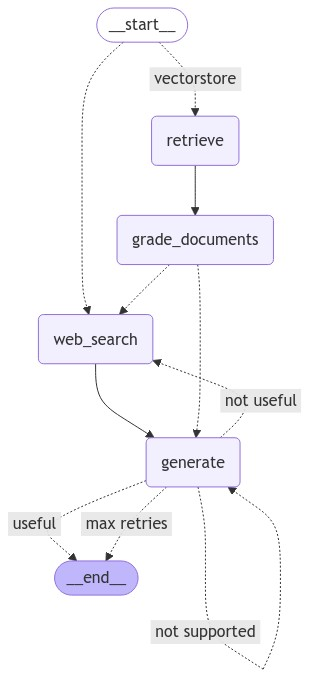

In [183]:
# Display the graph
display(Image(graph.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.API)))


In [184]:
# Test Graph
answer = graph.invoke({"question":"What kind of food I can eat while visiting Rome?"})["generation"]
print(answer)

---ROUTE QUESTION---
---ROUTE QUESTION TO RAG---
---RETRIEVE---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: MAX RETRIES REACHED---
You can try traditional Roman dishes such as Pasta alla carbonara, Bucatini all'amatriciana, and Roman gnocchi. Meat dishes like Saltimbocca alla romana, Coda alla vaccinara, and Trippa alla romana are also highly recommended. Additionally, you can explore local markets and try fresh produce, cheeses, and pastries.


In [186]:
# See more details
inputs = {"question": "What kind of food I can eat while visiting Paris?", "max_retries": 3}
for event in graph.stream(inputs, stream_mode="values"):
    print(event)

---ROUTE QUESTION---
---ROUTE QUESTION TO WEB SEARCH---
{'question': 'What kind of food I can eat while visiting Paris?', 'max_retries': 3, 'loop_step': 0}
---WEB SEARCH---
{'question': 'What kind of food I can eat while visiting Paris?', 'documents': Document(metadata={}, page_content="9. Poulet Rôti. There is nothing like the sight and smell of whole rotisserie chickens slowly turn on a roaster. Poulet rôti, also known as rotisserie chicken, is a classic Paris food that is inexpensive, easy to find in every neighborhood, and completely satisfying.\nThese sandwiches are made to perfection, and we’ll tell you more about just how amazing Parisian bread and cheese are in a moment, which should convince you to eat as a local would!\nWhere to get it: Croques can be found at nearly every Parisian restaurant, and each has its own take, but the best is at Faste.\n12. The flavor is a perfect harmony of sweet and savory, and although you could eat it anywhere in the world or make it at home, Pa